In [3]:
import tripadvisor_hotels_webcrawl as thw
import tripadvisor_cor_dataviz as tcd

In [4]:
import pandas as pd
from dotenv import load_dotenv
import io
import geopandas as gpd
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as ctx
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from esda.moran import Moran
from libpysal.weights import Queen

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

DATA_PATH = os.path.join(notebook_dir, "..", "data")
ENV_PATH = os.path.join(notebook_dir, "..", ".env")
load_dotenv(dotenv_path=ENV_PATH)

INFO_PATH = os.path.join(DATA_PATH, "Infogroup", "2023_Business_Academic_QCQ.txt")

# Ann Arbor

In [5]:
ann_arbor_info_df = tcd.create_infogroup_df(INFO_PATH, "ANN ARBOR", "MI")

In [6]:
ann_arbor_business_df = tcd.change_infogroup_column_names(ann_arbor_info_df)
ann_arbor_business_df.drop_duplicates(inplace=True)
ann_arbor_business_df = ann_arbor_business_df.reset_index(drop=True)
ann_arbor_business_df.head(5)

,name,city,street1,latitude,longitude,sales_volume,employee_size,parent_sales_volume
0,NaN,ANN ARBOR,1500 E MEDICAL CENTER DR,42.283534,-83.728684,543.0,3,NaN
1,TRIMBLE FINANCIAL SVC,ANN ARBOR,3893 RESEARCH PARK DR,42.234871,-83.735171,955.0,3,NaN
2,MERRILL LYNCH FNCL ADVISOR,ANN ARBOR,777 E EISENHOWER PKWY,42.244657,-83.737219,319.0,1,NaN
3,DIGITAL DOC,ANN ARBOR,414 S MAIN ST # 115,42.277382,-83.749103,3462.0,4,NaN
4,FISHER KRISTINA RAE,ANN ARBOR,2215 FULLER RD,42.286544,-83.715365,NaN,1,NaN


In [7]:
ann_arbor_foot_traffic_path = os.path.join(DATA_PATH, "foot-traffic", "ann_arbor.parquet")
ann_arbor_patterns_df = pd.read_parquet(ann_arbor_foot_traffic_path)

In [8]:
ann_arbor_patterns_df.loc[:, "city"] = ann_arbor_patterns_df.loc[:, "city"].str.lower().str.strip()
ann_arbor_patterns_df.loc[:, "year"] = ann_arbor_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
ann_arbor_foot_df = ann_arbor_patterns_df.loc[(ann_arbor_patterns_df.loc[:, "year"] >= 2018), :]
ann_arbor_foot_df.loc[:, "location_name"] = ann_arbor_foot_df.loc[:, "location_name"].str.upper().str.strip()
ann_arbor_foot_df.loc[:, "street_address"] = ann_arbor_foot_df.loc[:, "street_address"].str.upper().str.strip()
ann_arbor_foot_traffic_df = ann_arbor_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
ann_arbor_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [9]:
ann_arbor_foot_traffic_df.head(5)

,location_name,latitude,longitude,street_address,raw_visit_counts,raw_visitor_counts
0,1 800 CARS4CASH,42.209615,-83.733019,5455 S STATE RD,1623.0,768.0
1,16 HANDS,42.284325,-83.746091,407 N 5TH AVE FL 2,24.0,23.0
2,19 DRIPS,42.273684,-83.777626,2263 W LIBERTY ST,405.0,287.0
3,242 COMMUNITY CHURCH,42.276102,-83.801800,648 S WAGNER RD,18474.0,8600.0
4,3FIFTEEN ANN ARBOR RECREATIONAL,42.254874,-83.687473,3720 WASHTENAW AVE,1677.0,1341.0


In [44]:
ann_arbor_api_hotel_df = pd.read_csv(os.path.join(DATA_PATH, 
        "tripadvisor", "Ann_Arbor_hotels_api.csv")
)
ann_arbor_crawled_hotel_df = pd.read_csv(os.path.join(DATA_PATH, 
        "tripadvisor", "Ann_Arbor_hotels_crawled.csv")
)


In [45]:
ann_arbor_api_hotel_df.loc[:, "name"] = ann_arbor_api_hotel_df.loc[:, "name"].str.upper().str.strip()
ann_arbor_api_hotel_df.loc[:, "street1"] = ann_arbor_api_hotel_df.loc[:, "street1"].str.upper().str.strip()
ann_arbor_api_hotel_df.loc[:, "city"] = ann_arbor_api_hotel_df.loc[:, "city"].str.upper().str.strip()
ann_arbor_api_hotel_df.head(5)

,location_id,name,distance,address_string,city,street1,web_url,latitude,longitude,rating,num_reviews,price_level,number_of_rooms
0,89935,GRADUATE ANN ARBOR,0.301596,"615 E Huron St, Ann Arbor, MI 48104-1524",ANN ARBOR,615 E HURON ST,https://www.tripadvisor.com/Hotel_Review-g2955...,42.281250,-83.74155,4.0,682,$$$,207.0
1,95054,WEBER'S BOUTIQUE HOTEL,2.800484,"3050 Jackson Ave, Ann Arbor, MI 48103-1997",ANN ARBOR,3050 JACKSON AVE,https://www.tripadvisor.com/Hotel_Review-g2955...,42.284660,-83.79245,4.0,663,$$,158.0
2,8477216,RESIDENCE INN BY MARRIOTT ANN ARBOR DOWNTOWN,0.629792,"120 W Huron St, Ann Arbor, MI 48104-1318",ANN ARBOR,120 W HURON ST,https://www.tripadvisor.com/Hotel_Review-g2955...,42.281788,-83.74944,5.0,878,$$$$,110.0
3,9984935,HAMPTON INN & SUITES ANN ARBOR WEST,2.669941,"2910 Jackson Ave, Ann Arbor, MI 48103-2012",ANN ARBOR,2910 JACKSON AVE,https://www.tripadvisor.com/Hotel_Review-g2955...,42.283733,-83.78989,4.0,394,$$,100.0
4,77474,WYNDHAM GARDEN ANN ARBOR,2.595753,"2900 Jackson Ave, Ann Arbor, MI 48103-2012",ANN ARBOR,2900 JACKSON AVE,https://www.tripadvisor.com/Hotel_Review-g2955...,42.283340,-83.78842,3.0,828,$,162.0


In [46]:
ann_arbor_crawled_hotel_df.loc[:, "name"] = ann_arbor_crawled_hotel_df.loc[:, "name"].str.upper().str.strip()
ann_arbor_crawled_hotel_df.loc[:, "street1"] = ann_arbor_crawled_hotel_df.loc[:, "street1"].str.upper().str.strip()
ann_arbor_crawled_hotel_df.loc[:, "city"] = ann_arbor_crawled_hotel_df.loc[:, "city"].str.upper().str.strip()
ann_arbor_crawled_hotel_df.head(5)

,location_id,name,web_url,latitude,longitude,rating,num_reviews,price_level,address_string,city,street1,number_of_rooms
0,89928,THE KENSINGTON HOTEL,https://www.tripadvisor.com/Hotel_Review-g2955...,42.238980,-83.741350,4.0,1393,$$,"3500 South State Street, Ann Arbor, MI 48108-1632",ANN ARBOR,3500 SOUTH STATE STREET,200.0
1,12791623,HYATT PLACE ANN ARBOR,https://www.tripadvisor.com/Hotel_Review-g2955...,42.240670,-83.738400,4.5,589,$$,"3223 S State St, Ann Arbor, MI 48108-1625",ANN ARBOR,3223 S STATE ST,142.0
2,95063,ANN ARBOR REGENT HOTEL & SUITES,https://www.tripadvisor.com/Hotel_Review-g2955...,42.251580,-83.680145,4.5,1970,$$,"2455 Carpenter Rd, Ann Arbor, MI 48108-1103",ANN ARBOR,2455 CARPENTER RD,125.0
3,249992,STONE CHALET BED & BREAKFAST INN,https://www.tripadvisor.com/Hotel_Review-g2955...,42.268272,-83.722240,4.5,178,$$$,"1917 Washtenaw Ave, Ann Arbor, MI 48104-3654",ANN ARBOR,1917 WASHTENAW AVE,10.0
4,8477216,RESIDENCE INN BY MARRIOTT ANN ARBOR DOWNTOWN,https://www.tripadvisor.com/Hotel_Review-g2955...,42.281788,-83.749440,5.0,877,$$$$,"120 W Huron St, Ann Arbor, MI 48104-1318",ANN ARBOR,120 W HURON ST,110.0


In [13]:
from utils.config import ADDRESS_MAPPING
import usaddress
from fuzzywuzzy import fuzz
def standardize_address(address: str, mappings = ADDRESS_MAPPING):
    """_summary_

    Args:
        address (str): _description_
        mappings (Dict, optional): _description_. Defaults to ADDRESS_MAPPING.

    Returns:
        _type_: _description_
    """
    address = address.upper().strip()
    parsed_address = usaddress.parse(address)
    standardized_address = [mappings.get(text, text) for text, _ in parsed_address] 
    return " ".join(standardized_address)


def combined_similarity(hotel_address, hotel_name, business_address, business_name, 
        address_weight=0.5, name_weight=0.5
):
    """_summary_

    Args:
        hotel (_type_): _description_
        business (_type_): _description_
        address_weight (float, optional): _description_. Defaults to 0.5.
        name_weight (float, optional): _description_. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    address_score = fuzz.partial_ratio(hotel_address, business_address)
    name_score = fuzz.partial_ratio(hotel_name, business_name)
    combined_score = (address_weight * address_score) + (name_weight * name_score)
    return combined_score

def find_matching(hotel_df, hotel_name_column, hotel_address_column, 
        business_df, business_name_column, business_address_column,
        address_weight=0.5, name_weight=0.5, min_score=86
    ):
    """_summary_

    Args:
        hotel (_type_): _description_
        business_df (_type_): _description_
        address_weight (float, optional): _description_. Defaults to 0.5.
        name_weight (float, optional): _description_. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    indicies_lst = []
    
    for hotel_index, hotel in hotel_df.iterrows():
        if pd.isna(hotel[hotel_address_column]):
            continue
        if pd.isna(hotel[hotel_name_column]):
            continue
        hotel[hotel_address_column] = str(hotel[hotel_address_column])
        for business_index, business in business_df.iterrows():
            # print(business, hotel)
            if pd.isna(business[business_address_column]): 
                continue
            if pd.isna(business[business_name_column]):
                continue
            business[business_address_column] = str(business[business_address_column])
            # print (hotel[hotel_address_column][0:3], business[business_address_column][0:3])
            if hotel[hotel_address_column][0:3] == business[business_address_column][0:3]:
                hotel["standardized_address"] = standardize_address(hotel[hotel_address_column])
                business["standardized_address"] = standardize_address(business[business_address_column])
                hotel["standardized_name"] = hotel[hotel_name_column]
                business["standardized_name"] = business[business_name_column]
                similarity_score = combined_similarity(
                        hotel["standardized_address"], 
                        hotel["standardized_name"],
                        business["standardized_address"],
                        business["standardized_name"], 
                        address_weight, name_weight
                )
                if similarity_score > min_score:
                    print(f"Hotel: {hotel[hotel_name_column]}, {hotel[hotel_address_column]} Business: {business[business_name_column]}, {business[business_address_column]} Similarity: {similarity_score}")
                    indicies_lst.append((hotel_index, business_index, similarity_score))
                    break
    
    return indicies_lst

/opt/homebrew/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [14]:
indicies_lst = find_matching(ann_arbor_api_hotel_df, "name", 
        "street1", ann_arbor_business_df, "name", "street1"
)

Hotel: RESIDENCE INN BY MARRIOTT ANN ARBOR DOWNTOWN, 120 W HURON ST Business: RESIDENCE INN BY MARRIOTT ANN, 120 W HURON ST Similarity: 100.0
Hotel: HAMPTON INN & SUITES ANN ARBOR WEST, 2910 JACKSON AVE Business: HAMPTON INN-SUITES ANN ARBOR, 2910 JACKSON AVE Similarity: 94.5
Hotel: WYNDHAM GARDEN ANN ARBOR, 2900 JACKSON AVE Business: WYNDHAM GARDEN ANN ARBOR, 2900 JACKSON AVE Similarity: 100.0
Hotel: BELL TOWER HOTEL, 300 S THAYER ST Business: BELL TOWER HOTEL, 300 S THAYER ST Similarity: 100.0
Hotel: INN AT THE MICHIGAN LEAGUE, 911 N UNIVERSITY AVE Business: MICHIGAN LEAGUE, 911 N UNIVERSITY AVE Similarity: 100.0
Hotel: HOMEWOOD SUITES BY HILTON ANN ARBOR, 2457 S STATE ST. Business: HOMEWOOD SUITES BY HILTON ANN, 2457 S STATE ST Similarity: 100.0
Hotel: SONESTA SIMPLY SUITES DETROIT ANN ARBOR, 701 WAYMARKET DRIVE Business: SONESTA SIMPLY SUITES DETROIT, 701 WAYMARKET DR Similarity: 100.0
Hotel: HOLIDAY INN & SUITES ANN ARBOR UNIV. MICHIGAN AREA, AN IHG HOTEL, 3155 BOARDWALK ST Busine

In [15]:
def merge_data(hotel_df, business_df, indices_lst):
    """_summary_

    Args:
        hotel_df (_type_): _description_
        business_df (_type_): _description_
        indicies_lst (_type_): _description_

    Returns:
        _type_: _description_
    """
    merged_rows = []
    hotel_df_copy = hotel_df.copy()
    business_df_copy = business_df.copy()
    
    for hotel_index, business_index, _ in indices_lst:
        hotel = hotel_df_copy.loc[hotel_index].copy()
        business = business_df_copy.loc[business_index].copy()

        for column in business.index:
            if column not in hotel.index:
                hotel[column] = business[column]
            elif pd.isna(hotel[column]) and not pd.isna(business[column]):
                hotel[column] = business[column]

        merged_rows.append(hotel)

    merged_df = pd.DataFrame(merged_rows)

    hotel_df_copy.drop([hotel_index for hotel_index, _, _ in indices_lst], inplace=True)
    business_df_copy.drop([business_index for _, business_index, _ in indices_lst], inplace=True)

    complete_df = pd.concat([merged_df, hotel_df, business_df], axis=0).reset_index(drop=True)

    return merged_df, complete_df


In [16]:
ann_arbor_hb_merged_df, ann_arbor_hotel_business_df = merge_data(ann_arbor_api_hotel_df, ann_arbor_business_df, indicies_lst)

In [17]:
correlation_matrix = ann_arbor_hotel_business_df.loc[:, ["rating", "number_of_rooms", "num_reviews", "sales_volume", "employee_size", "parent_sales_volume"]].corr()
correlation_matrix

,rating,number_of_rooms,num_reviews,sales_volume,employee_size,parent_sales_volume
rating,1.000000,0.110708,0.284694,0.140734,0.163250,0.528530
number_of_rooms,0.110708,1.000000,0.266559,0.115656,0.143749,0.010899
num_reviews,0.284694,0.266559,1.000000,0.171554,0.199451,0.082533
sales_volume,0.140734,0.115656,0.171554,1.000000,0.088961,0.005625
employee_size,0.163250,0.143749,0.199451,0.088961,1.000000,-0.016320
parent_sales_volume,0.528530,0.010899,0.082533,0.005625,-0.016320,1.000000


In [18]:
ann_arbor_hotel_business_df.columns

Index(['location_id', 'name', 'distance', 'address_string', 'city', 'street1',
       'web_url', 'latitude', 'longitude', 'rating', 'num_reviews',
       'price_level', 'number_of_rooms', 'sales_volume', 'employee_size',
       'parent_sales_volume'],
      dtype='object')

In [26]:
gdf = gpd.GeoDataFrame(ann_arbor_hotel_business_df.loc[:, ["latitude", "longitude", "number_of_rooms", "sales_volume"]], geometry=gpd.points_from_xy(ann_arbor_hotel_business_df.longitude, ann_arbor_hotel_business_df.latitude))

weights = Queen.from_dataframe(gdf)

moran_latitude = Moran(gdf["latitude"], weights)
print(f"Moran's I (Latitude): {moran_latitude.I}, p-value: {moran_latitude.p_sim}")

moran_longitude = Moran(gdf["longitude"], weights)
print(f"Moran's I (Longitude): {moran_longitude.I}, p-value: {moran_longitude.p_sim}")

/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/3352231919.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(gdf)


Moran's I (Latitude): 0.8499158221769851, p-value: 0.001
Moran's I (Longitude): 0.9920953011120759, p-value: 0.001


In [48]:
crawled_ann_arbor_hb_merged_df, crawled_ann_arbor_hotel_business_df = merge_data(ann_arbor_crawled_hotel_df, ann_arbor_business_df, indicies_lst)

In [49]:
correlation_matrix = crawled_ann_arbor_hotel_business_df.loc[:, ["rating", "number_of_rooms", "num_reviews", "sales_volume", "employee_size", "parent_sales_volume"]].corr()
correlation_matrix

,rating,number_of_rooms,num_reviews,sales_volume,employee_size,parent_sales_volume
rating,1.000000,-0.172100,0.097989,0.065689,0.081966,0.108220
number_of_rooms,-0.172100,1.000000,0.431088,0.106322,0.138046,0.174001
num_reviews,0.097989,0.431088,1.000000,0.115821,0.094200,0.118379
sales_volume,0.065689,0.106322,0.115821,1.000000,0.088961,0.005625
employee_size,0.081966,0.138046,0.094200,0.088961,1.000000,-0.016320
parent_sales_volume,0.108220,0.174001,0.118379,0.005625,-0.016320,1.000000


In [51]:
gdf = gpd.GeoDataFrame(crawled_ann_arbor_hotel_business_df.loc[:, ["latitude", "longitude", "number_of_rooms", "sales_volume"]], geometry=gpd.points_from_xy(crawled_ann_arbor_hotel_business_df.longitude, crawled_ann_arbor_hotel_business_df.latitude))

weights = Queen.from_dataframe(gdf)

moran_latitude = Moran(gdf["latitude"], weights)
print(f"Moran's I (Latitude): {moran_latitude.I}, p-value: {moran_latitude.p_sim}")

moran_longitude = Moran(gdf["longitude"], weights)
print(f"Moran's I (Longitude): {moran_longitude.I}, p-value: {moran_longitude.p_sim}")

/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/3839079273.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(gdf)


Moran's I (Latitude): 0.850128181224683, p-value: 0.001
Moran's I (Longitude): 0.9921356410611504, p-value: 0.001


In [52]:
ann_arbor_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [62]:
from scipy.spatial import distance_matrix
import pandas as pd
ann_arbor_foot_traffic_df.columns


hotel_coords = ann_arbor_api_hotel_df[["latitude", "longitude"]].values
foot_traffic_coords = ann_arbor_foot_traffic_df[["latitude", "longitude"]].values

dist_matrix = distance_matrix(hotel_coords, foot_traffic_coords)

foot_traffic_counts = ann_arbor_foot_traffic_df["raw_visit_counts"].values
weight_matrix = 1 / (dist_matrix + 1e-10)

weighted_traffic = weight_matrix @ foot_traffic_counts 
ann_arbor_api_hotel_df["weighted_traffic"] = weighted_traffic

In [63]:
correlation = ann_arbor_api_hotel_df[["number_of_rooms", "weighted_traffic"]].corr()
print(correlation)

                  number_of_rooms  weighted_traffic
number_of_rooms          1.000000         -0.338702
weighted_traffic        -0.338702          1.000000


In [55]:
from scipy.spatial import distance_matrix
import pandas as pd
ann_arbor_foot_traffic_df.columns


hotel_coords = ann_arbor_crawled_hotel_df[["latitude", "longitude"]].values
foot_traffic_coords = ann_arbor_foot_traffic_df[["latitude", "longitude"]].values

dist_matrix = distance_matrix(hotel_coords, foot_traffic_coords)

foot_traffic_counts = ann_arbor_foot_traffic_df["raw_visit_counts"].values
weight_matrix = 1 / (dist_matrix + 1e-10)

weighted_traffic = weight_matrix @ foot_traffic_counts 
ann_arbor_crawled_hotel_df["weighted_traffic"] = weighted_traffic

In [59]:
correlation = ann_arbor_crawled_hotel_df[["number_of_rooms", "weighted_traffic"]].corr()
print(correlation)

                  number_of_rooms  weighted_traffic
number_of_rooms          1.000000         -0.153749
weighted_traffic        -0.153749          1.000000


/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/1203128347.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=ann_arbor_api_hotel_df, x='longitude', y='latitude', cmap='Blues', shade=True)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/1203128347.py:5: FutureWarning: 

`shade` is now deprecated in favo

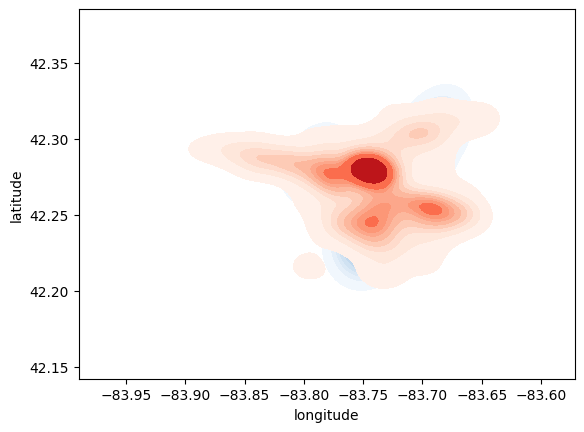

KDE Correlation: -0.041961071973565835


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=ann_arbor_api_hotel_df, x='longitude', y='latitude', cmap='Blues', shade=True)
sns.kdeplot(data=ann_arbor_foot_traffic_df, x='longitude', y='latitude', cmap='Reds', shade=True)
plt.show()

from scipy.stats import gaussian_kde

hotel_kde = gaussian_kde(hotel_coords.T)
foot_traffic_kde = gaussian_kde(foot_traffic_coords.T)

hotel_density = hotel_kde(hotel_coords.T)
foot_traffic_density = foot_traffic_kde(foot_traffic_coords.T)

correlation = pd.Series(hotel_density).corr(pd.Series(foot_traffic_density))
print(f"KDE Correlation: {correlation}")

/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/2238498036.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=ann_arbor_crawled_hotel_df, x='longitude', y='latitude', cmap='Blues', shade=True)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/5d/ntxdl44j0m57__z99jhcwvw00000gn/T/ipykernel_47277/2238498036.py:5: FutureWarning: 

`shade` is now deprecated in 

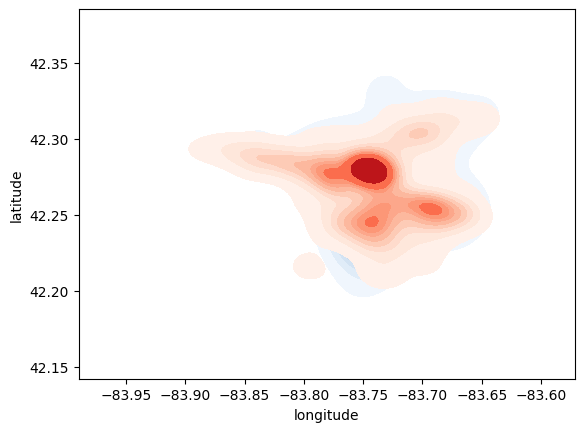

KDE Correlation: -0.041961071973565835


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=ann_arbor_crawled_hotel_df, x='longitude', y='latitude', cmap='Blues', shade=True)
sns.kdeplot(data=ann_arbor_foot_traffic_df, x='longitude', y='latitude', cmap='Reds', shade=True)
plt.show()

from scipy.stats import gaussian_kde

hotel_kde = gaussian_kde(hotel_coords.T)
foot_traffic_kde = gaussian_kde(foot_traffic_coords.T)

hotel_density = hotel_kde(hotel_coords.T)
foot_traffic_density = foot_traffic_kde(foot_traffic_coords.T)

correlation = pd.Series(hotel_density).corr(pd.Series(foot_traffic_density))
print(f"KDE Correlation: {correlation}")